## 1. Import Necessary Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from altusi import utils
import altusi.utils.visualizer as vis
import altusi.configs.config as cfg
from altusi.utils.logger import *

In [2]:
import numpy as np

import mxnet as mx
from mxnet import nd, autograd, gluon, context
from mxnet.gluon.data.vision import transforms, CIFAR10

## 2. Prepare Data

### 2.1 Define Data Transformers

In [3]:
train_transformer = transforms.Compose([
    transforms.RandomFlipLeftRight(),
    transforms.ToTensor(),
    transforms.Normalize(cfg.CIFAR10_MEAN, cfg.CIFAR10_STD)
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cfg.CIFAR10_MEAN, cfg.CIFAR10_STD)
])

LOG(INFO, 'Data Transformers defining done')

[2019-08-07 20:31:58] [INFO]  Data Transformers defining done


### 2.2 Load Dataset

In [4]:
train_dataset = CIFAR10(train=True)
test_dataset = CIFAR10(train=False)

LOG(INFO, 'Dataset loading done')

[2019-08-07 20:31:59] [INFO]  Dataset loading done


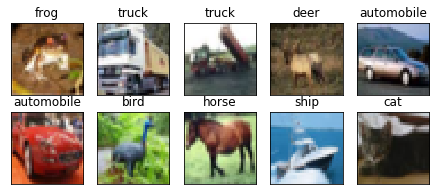

In [5]:
X, y = train_dataset[:10]

vis.show_images(X, 2, 5, 
               titles=[cfg.CIFAR_CLASSES[cls] for cls in y])

### 2.3 Define Data Loaders

In [6]:
BATCH_SIZE = cfg.BATCH_SIZE

train_loader = gluon.data.DataLoader(
    train_dataset.transform_first(train_transformer),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

test_loader = gluon.data.DataLoader(
    test_dataset.transform_first(test_transformer),
    batch_size=BATCH_SIZE,
    num_workers=4
)

LOG(INFO, 'Data Loaders defining done')

[2019-08-07 20:32:00] [INFO]  Data Loaders defining done


## 3. Setup Training System

In [7]:
from altusi.models import VGG11, VGG13, VGG16, VGG19

#net = VGG11(nclasses=cfg.CIFAR_NCLASSES)
#net = VGG13(nclasses=cfg.CIFAR_NCLASSES)
#net = VGG16(nclasses=cfg.CIFAR_NCLASSES)
net = VGG19(nclasses=cfg.CIFAR_NCLASSES)

LOG(INFO, 'Network setup done')

[2019-08-07 20:32:00] [INFO]  Network setup done


In [8]:
net

VGG(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (7): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (9): Activation(relu)
    (10): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=

In [9]:
ctx = context.gpu(0) if context.num_gpus() else context.cpu()

LOG(INFO, 'Device in Use:', ctx)

[2019-08-07 20:32:00] [INFO]  Device in Use: gpu(0)


In [10]:
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = 'sgd'

net.initialize(init=mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()

trainer = gluon.Trainer(
    net.collect_params(),
    optimizer,
    {'learning_rate':cfg.LR, 'wd':cfg.WD, 'momentum':cfg.MOMENTUM}
)

LOG(INFO, 'Training system setup done')

[2019-08-07 20:32:02] [INFO]  Training system setup done


## 4. Training Procedure

In [11]:
def evaluate_accuracy_loss(net, loader, criterion, ctx):
    metric = mx.metric.Accuracy()
    loss = 0
    sample_cnt = 0
    
    for i, (X, y) in enumerate(train_loader):
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        
        y_hat = net(X)
        l = criterion(y_hat, y)
        
        metric.update(labels=[y], preds=[y_hat])
        loss += l.sum().asscalar()
        sample_cnt += X.shape[0]
        
    return metric.get(), loss / sample_cnt

[2019-08-07 20:44:45] [INFO]  Epoch: 30
[2019-08-07 20:44:45] [INFO]  	train-acc:  0.9249
[2019-08-07 20:44:45] [INFO]  	train-loss: 0.2488
[2019-08-07 20:44:45] [INFO]  	val-acc:    0.9059
[2019-08-07 20:44:45] [INFO]  	val-loss:   0.3186


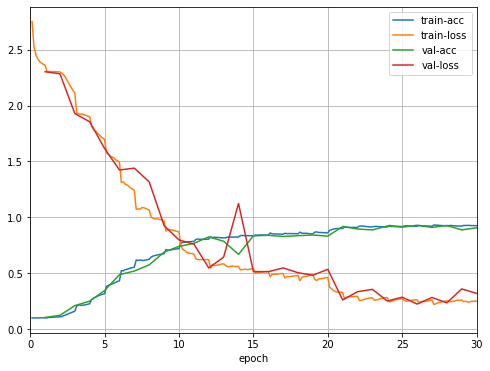

In [12]:
animator = vis.Animator(
    xlabel='epoch',
    legend=['train-acc', 'train-loss', 'val-acc', 'val-loss'],
    xlim=[0, cfg.NEPOCHS],
    figsize=(8, 6)
)

LR_DECAY_EPOCHS = [10, 20] + [np.inf]
lr_decay_idx = 0

train_metric = mx.metric.Accuracy()
for epoch in range(cfg.NEPOCHS):
    train_metric.reset()
    train_loss_total = 0
    sample_cnt = 0
    
    if epoch == LR_DECAY_EPOCHS[lr_decay_idx]:
        trainer.set_learning_rate(trainer.learning_rate * cfg.LR_DECAY_FACTOR)
        lr_decay_idx += 1
        
    for i, (X, y) in enumerate(train_loader):
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        
        with autograd.record():
            y_hat = net(X)
            l = criterion(y_hat, y)
        l.backward()
        trainer.step(X.shape[0])
        
        train_metric.update(labels=[y], preds=[y_hat])
        train_loss_total += l.sum().asscalar()
        sample_cnt += X.shape[0]
        
        name, train_acc = train_metric.get()
        train_loss = train_loss_total / sample_cnt
        
        if (i+1) % 50 == 0 or i+1 == len(train_loader):
            animator.add(epoch + i/len(train_loader), 
                        (train_acc, train_loss, None, None))
            
    (name, val_acc), val_loss = evaluate_accuracy_loss(net, test_loader, criterion, ctx)
    animator.add(epoch+1, (None, None, val_acc, val_loss))
    
    LOG(INFO, 'Epoch:', epoch+1)
    LOG(INFO, '\ttrain-acc:  {:.4f}'.format(train_acc))
    LOG(INFO, '\ttrain-loss: {:.4f}'.format(train_loss))
    LOG(INFO, '\tval-acc:    {:.4f}'.format(val_acc))
    LOG(INFO, '\tval-loss:   {:.4f}'.format(val_loss))

## 5. Test Procedure

In [13]:
(name, val_acc), val_loss = evaluate_accuracy_loss(net, test_loader, criterion, ctx)
LOG(INFO, 'Accuracy: {:.4f}'.format(val_acc))

[2019-08-07 20:44:52] [INFO]  Accuracy: 0.9066
